In [1]:
import Lib_Prediction as LP
import Lib_data as LD
from importlib import reload
reload(LP)
reload(LD)

from importlib import reload
import Lib_data as LD
reload(LD)
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import(confusion_matrix,
                            accuracy_score,
                            precision_score,
                            recall_score,
                            make_scorer)
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from joblib import dump, load
from sklearn.metrics import(confusion_matrix,
                            accuracy_score,
                            precision_score,
                            recall_score)

from sklearn.metrics import classification_report
import ipywidgets as widgets
from ipywidgets.embed import embed_minimal_html
from sklearn.decomposition import PCA
import Lib_Scrap_last_saison as LS

## Changements depuis la soutenance

- `Effet de long-terme` : Mise en place d'un indicateur **Elo_rating** permettant de mesurer la performance d'une équipe sur la base d'un score évolutif de matchs en matchs.

- `Analyse par composantes principales` : Diminution des dimensions des predicteurs. En 3 composantes on détient ~96% de la variance expliquée des 7 varaibles explicatives utilisées avant.

- `Scraping` : Changement du code scource du site. Le scraping se décomposait en 2 parties : récupération des matchs de 2004 à 2022 puis des match en cours. </br>
Nous avons fait ainsi le choix de recoder uniquement la récupération de la saison en cours pour nous permettre d'actualiser les données et avoir les derniers matchs avant prédictions.

- `Signatures` : Vérifications et changements éventuels

- `Configuration de black`


# Lancement du scraping pour la dernière saison

 - Récupère les données et remplace le fichier Extraction2.csv.

 - À la fin de la saison, concaténer Extraction2 avec Extraction 1 

In [2]:
#LS.crea_DF_derniere_saison()

# Lib_Data

In [2]:
Cdata = LD.Data_match()

### Base de données scrappée

In [5]:
Cdata.Show_extract()

,index,Equipe_D,Equipe_E,Cote_D,Cote_N,Cote_E,Score_D,Score_E,Saison
0,0,Rennes,Paris SG,5.25,4.22,1.64,1,0,2022-2023
1,1,Monaco,AC Ajaccio,1.40,4.73,8.75,7,1,2022-2023
2,2,Angers,Clermont,2.39,3.35,3.11,1,2,2022-2023
3,3,Montpellier,Nantes,2.48,3.29,3.02,0,3,2022-2023
4,4,Reims,Nice,2.52,3.25,2.98,0,0,2022-2023
...,...,...,...,...,...,...,...,...,...
6928,6936,Rennes,Paris SG,2.89,3.05,2.24,2,1,2004-2005
6929,6937,Sochaux,AC Ajaccio,1.57,3.45,5.25,1,0,2004-2005
6930,6938,Toulouse,Lens,2.33,3.04,2.76,0,0,2004-2005
6931,6939,St Etienne,Monaco,3.13,3.09,2.11,0,1,2004-2005


### N derniers match d'une équipe (ici 5)

In [6]:
Cdata.N_last_match(5,'Nice')

,index,Equipe_D,Equipe_E,Cote_D,Cote_N,Cote_E,Score_D,Score_E,Saison
4,4,Reims,Nice,2.52,3.25,2.98,0,0,2022-2023
11,11,Nice,Montpellier,1.86,3.64,4.40,6,1,2022-2023
20,20,Rennes,Nice,1.88,3.69,4.30,2,1,2022-2023
31,31,Nice,Lens,3.06,3.15,2.55,0,0,2022-2023
49,49,Lyon,Nice,1.76,3.81,4.83,1,1,2022-2023


### Statistiques comparatives sur les N derniers matchs (ici 5)

In [7]:
Cdata.Statistiques(5, 'Lens', 'Paris SG')

,Lens,Paris SG
Victoire,3,3
Nul,2,0
Defaite,0,2
But,8,10
Encaisse,4,5
Moyenne_cote,2.234,1.442
Points,44,47
Elo_rating,1653.65,1735.84


### Création des prédicteurs statistiques pour la prédiction

In [8]:
Cdata.Compare_perf_equipe(5,'Nice','Paris SG')

,Diff_Victoire,Diff_Nul,Diff_Defaite,Diff_But,Diff_Encaisse,Diff_Moyenne_cote,Diff_Points,Diff_Elo_rating
Nice-Paris SG,-2,3,-1,-2,-1,1.964,-22,-169.28


### Base de données finale

In [3]:
Data = Cdata.Final_DataFrame(5)
Data

,Equipe_D,Equipe_E,Cote_D,Cote_N,Cote_E,Score_D,Score_E,Saison,Winner_D,Winner_E,...,Diff_But,Diff_Encaisse,Diff_Moyenne_cote,Diff_Elo_Before,Points_a,Points_b,Diff_Points,PCA1,PCA2,PCA3
0,Rennes,Paris SG,5.25,4.22,1.64,1,0,2022-2023,1,0,...,-5,3,0.884,-138.207241,34,47,-13,-1.111634,-0.686729,-0.064543
1,Monaco,AC Ajaccio,1.40,4.73,8.75,7,1,2022-2023,1,0,...,3,0,-1.33,217.724970,34,15,19,1.569751,-0.375230,0.546531
2,Angers,Clermont,2.39,3.35,3.11,1,2,2022-2023,0,1,...,-3,2,2.728,-94.434829,8,25,-17,-1.404862,-0.033647,0.063579
3,Montpellier,Nantes,2.48,3.29,3.02,0,3,2022-2023,0,1,...,3,7,1.11,-59.059743,17,18,-1,-0.091884,0.066036,2.096297
4,Reims,Nice,2.52,3.25,2.98,0,0,2022-2023,0,0,...,-2,-1,-0.012,-32.208186,24,24,0,0.022166,-0.157095,-0.565370
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6773,Lyon,Bastia,1.43,3.70,6.50,0,0,2004-2005,0,0,...,0,0,-1.046,2.015667,0,0,0,0.035534,0.083591,-0.043506
6774,Marseille,Toulouse,1.68,3.22,4.64,1,0,2004-2005,1,0,...,-5,1,-0.85,-28.438570,0,0,0,-0.066319,-1.299678,-0.269481
6775,Nantes,Istres,1.66,3.25,4.71,1,0,2004-2005,1,0,...,-1,-2,-2.158,1.051358,0,0,0,0.049577,0.071687,-0.660948
6776,Strasbourg,Lens,2.71,2.95,2.43,2,2,2004-2005,0,0,...,-1,9,1.22,-37.191733,0,0,0,-0.113794,-1.278554,2.140661


# Lib_Prediction

### Chargement de la classe Prediction

Si vous souhaitez travailler sur la prédiction pour les équipes à domicile :

`Target = Data[['Winner_D'] `

` P = LP.Prediction(Target, Predictor, 'domicile')`

Si vous souhaitez travailler sur la prédiction pour les équipes à domicile :

`Target = Data[['Winner_E'] `

` P = LP.Prediction(Target, Predictor, 'exterieur')`

In [4]:
Target = Data[['Winner_D']]
Predictor = Data[['Cote_D','Cote_N','Cote_E','PCA1', 'PCA2', 'PCA3', 'Diff_Elo_Before']]
P = LP.Prediction(Target, Predictor, 'domicile')

### Entrainer un modèle et importer le meilleur dans un fichier .joblib

Ici vous pouvez entrainer plusieurs miodèles avec la commande P.`Choisissez le modèle`

`P.Logistic_Regression()`

`P.K_Nearest_Neighbors()`

`P.Ada_boost()`

`P.Reseau_neuronne()`

Une fois les meilleurs hyperparamètres trouvé, le meilleur modèle sera enregistré directement dans le dossier du projet sous la forme :

`Nom_du_modèle_(exterieur/domicile).joblib`

Le fichier est écrasé et remplacé s'il existait déjà.

In [ ]:
P.Logistic_Regression()

### Chargement du modèle (appel du .joblib)

In [5]:
lr_gs = P.Load_Modele('lr_gs')

### Affichage des performance du modèle sur l'ensemble de test

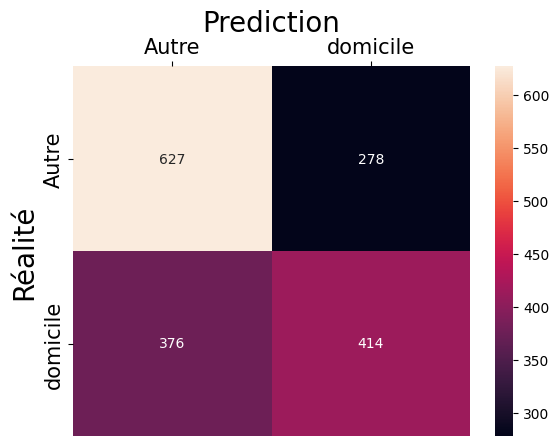

,Précision,Sensibilité,Spécificité,Précision Positif,Précision Négatif,AUC,Accuracy,Spé+Sen
Score,0.61,0.52,0.69,0.6,0.63,0.61,0.61,1.22


In [7]:
P.Performances(lr_gs)

### DataFrame réalité vs prédiction 

In [21]:
P.Tab_Realite_Pred(lr_gs)

,Winner_D,Cotedomicile,Prediction,Autres,domicile,Esperance,Decision
0,0,1.33,1,0.123687,0.876313,0.165496,1
1,0,2.11,0,0.520816,0.479184,0.011078,0
2,0,3.04,0,0.690760,0.309240,-0.059910,0
3,1,2.70,0,0.652196,0.347804,-0.060930,0
4,0,5.12,0,0.867851,0.132149,-0.323397,0
...,...,...,...,...,...,...,...
1690,1,2.35,0,0.606484,0.393516,-0.075237,0
1691,0,3.48,0,0.758063,0.241937,-0.158060,0
1692,1,2.75,0,0.657941,0.342059,-0.059338,0
1693,1,2.83,0,0.676216,0.323784,-0.083692,0


### Histogramme dinamique des performance du modèle - intervalle de preédiction

In [22]:
P.Histogramme_pred(lr_gs)

interactive(children=(FloatSlider(value=0.5, description='mini', max=1.0, min=0.5, step=0.01), FloatSlider(val…

### Indicateur performance dans intervalle prediction

In [23]:
P.Indicateurs_Pred(0.70,0.75, lr_gs)

('9.6%', '-15.58%', '55.93%')

Ce notebook vous a présenté les différentes fonctions que l'on retrouve dans les différentes librairies. 

Nous avons fait le choix de construire le projet de telle sorte que l'utilisateur n'ai pas accès à la construction des modèles et du code. 

Nous voulions une utilisation facile et des résultats qui apparaissent rapidement.

Pour ce faire l'application (app.py -> script) utilise la `Logistic Regression classifier` de `sklearn` qui est le meilleur modèle selon le critère de précision et de quantité de matchs prédit.

Ainsi le fichier `Logistic_Regrssion_domicile.joblib` et `Logistic_Regrssion_exterieur.joblib` sont appellés par l'application ce qui évite à l'utilisateur d'attendre lorsqu'il demande une prédiction.